In [68]:
import numpy as np
from pathlib import Path

prefix = '../data/DT/DT_txt/'


def read_txt(filename):
    cur_file = Path(prefix + filename + '.txt')
    lines = cur_file.read_text().split('\n')
    lines.pop(0)
    lines.pop(0)
    ys = []
    xs = []
    for i in range(0, len(lines) - 1):
        xs.append(list(lines[i].split()))
        ys.append(xs[i].pop())
    return xs, ys


datasets = []
types = ["train", "test"]
for n in range(1, 22):
    cur_data = []
    for t in types:
        file_name = f"{n:02d}_" + t
        cur_data.append(read_txt(file_name))
    datasets.append(cur_data)
    # print(datasets[0][0][0][0], datasets[0][0][1][0])
    # idx1 - dataset number | idx2 - 0=train, 1=test | idx3 - 0=xs, 1=ys | idx4 - number of x or y

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

criteria = ["gini", "entropy"]
splitters = ["best", "random"]
heights = [h for h in range(1, 30)]


def get_accuracy(data_number, criterion, splitter, max_depth):
    train = datasets[data_number][0]
    test = datasets[data_number][1]
    decision_tree = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
    decision_tree.fit(train[0], train[1])
    return accuracy_score(test[1], decision_tree.predict(test[0]))


best_params = [{} for _ in range(len(datasets))]


def calculate_best_params():
    for data_number in range(len(datasets)):
        cur_best_accuracy = 0
        for criterion in criteria:
            for splitter in splitters:
                for max_depth in heights:
                    cur_accuracy = get_accuracy(data_number, criterion, splitter, max_depth)
                    if cur_accuracy > cur_best_accuracy:
                        cur_best_accuracy = cur_accuracy
                        best_params[data_number] = {'dataset_number': data_number + 1,
                                                    'accuracy': cur_accuracy,
                                                    'criterion': criterion,
                                                    'splitter': splitter,
                                                    'max_depth': max_depth}

In [70]:
calculate_best_params()

In [71]:
for d in best_params:
    print(d)

{'dataset_number': 1, 'accuracy': 0.9997429966589566, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3}
{'dataset_number': 2, 'accuracy': 0.7012722646310433, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9}
{'dataset_number': 3, 'accuracy': 1.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 1}
{'dataset_number': 4, 'accuracy': 0.9954782608695653, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5}
{'dataset_number': 5, 'accuracy': 0.9956709956709957, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 1}
{'dataset_number': 6, 'accuracy': 0.9988962472406181, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3}
{'dataset_number': 7, 'accuracy': 0.9967441860465116, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3}
{'dataset_number': 8, 'accuracy': 0.997920997920998, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 2}
{'dataset_number': 9, 'accuracy': 0.8549019607843137, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5}

In [74]:
min_max_depth = 1
max_max_depth = 14

min_depth_data_number = 2
min_depth_best_criterion = 'gini'
min_depth_best_splitter = 'best'

max_depth_data_number = 20
max_depth_best_criterion = 'entropy'
max_depth_best_splitter = 'best'

def get_accuracy_train(data_number, criterion, splitter, max_depth):
    train = datasets[data_number][0]
    decision_tree = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
    decision_tree.fit(train[0], train[1])
    return accuracy_score(train[1], decision_tree.predict(train[0]))


xs = [h for h in range(min_max_depth, max_max_depth)]
ys_max = []
ys_max_train = []
ys_min = []
ys_min_train = []
for max_depth in xs:
    ys_min.append(get_accuracy(min_depth_data_number, min_depth_best_criterion, min_depth_best_splitter, max_depth))
    ys_min_train.append(get_accuracy_train(min_depth_data_number, min_depth_best_criterion, min_depth_best_splitter, max_depth))
    ys_max.append(get_accuracy(max_depth_data_number, max_depth_best_criterion, max_depth_best_splitter, max_depth))
    ys_max_train.append(get_accuracy_train(max_depth_data_number, max_depth_best_criterion, max_depth_best_splitter, max_depth))

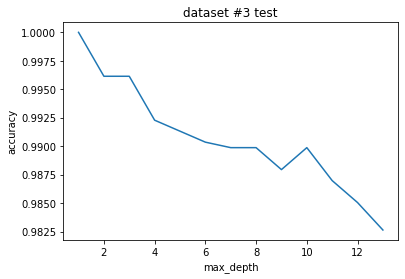

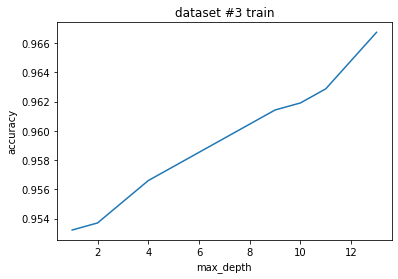

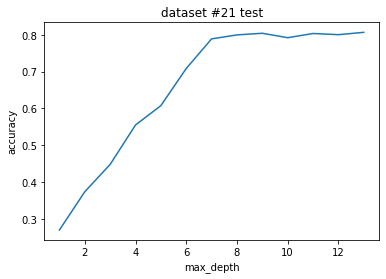

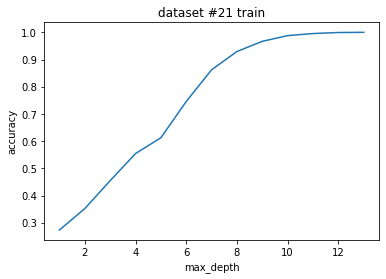

In [75]:
import matplotlib.pyplot as plt

def draw_plot(xs, ys, title):
    plt.plot(xs, ys)
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.title(title)
    plt.show()

draw_plot(xs, ys_min, 'dataset #3 test')
draw_plot(xs, ys_min_train, 'dataset #3 train')
draw_plot(xs, ys_max, 'dataset #21 test')
draw_plot(xs, ys_max_train, 'dataset #21 train')

In [66]:
import random

# data - dataset[i][j] (train / test lvl)
def get_random_subset(data, size):
    xs = []
    ys = []
    for _ in range(size):
        idx = random.randint(0, len(data[0]) - 1)
        xs.append(data[0][idx])
        ys.append(data[1][idx])
    return xs, ys


forest = []


def predict_one_object(xs):
    predictions = {}
    for tree in forest:
        pred = tree.predict(xs)
        prediction = pred[0]
        if prediction not in predictions:
            predictions[prediction] = 1
        else:
            predictions[prediction] += 1
    res_prediction = max(predictions, key=predictions.get)
    return res_prediction


def predict(xs):
    ys = []
    for x in xs:
        ys.append(predict_one_object([x]))
    return ys


def create_forest(data_number, trees_count, size, criterion=None, splitter=None):
    forest.clear()
    train = datasets[data_number][0]
    for _ in range(trees_count):
        tree = DecisionTreeClassifier()
        xs, ys = get_random_subset(train, size)
        tree.fit(xs, ys)
        forest.append(tree)


def get_forest_accuracy(data_number, is_train=False, criterion=None, splitter=None):
    train = datasets[data_number][0]
    test = datasets[data_number][1]
    trees_count = 100
    # size = int(np.sqrt(len(train)))
    size = 100
    create_forest(data_number, trees_count, size)
    if is_train:
        return accuracy_score(predict(train[0]), train[1])
    else:
        return accuracy_score(predict(test[0]), test[1])


best_params_forest = [{} for _ in range(len(datasets))]
best_params_forest_train = [{} for _ in range(len(datasets))]


def print_accuracy_forest():
    for data_number in range(len(datasets)):
        accuracy = get_forest_accuracy(data_number)
        accuracy_train = get_forest_accuracy(data_number, True)
        print('dataset #', data_number, ', test accuracy =', accuracy, ' train accuracy =', accuracy_train)

In [67]:
print_accuracy_forest()

dataset # 0 , test accuracy = 0.9964019532253919  train accuracy = 0.9434592649704446
dataset # 1 , test accuracy = 0.3732824427480916  train accuracy = 0.39592875318066156
dataset # 2 , test accuracy = 1.0  train accuracy = 0.95274831243973
dataset # 3 , test accuracy = 0.8605217391304348  train accuracy = 0.8507826086956521
dataset # 4 , test accuracy = 0.9978354978354979  train accuracy = 0.9718614718614719
dataset # 5 , test accuracy = 0.9839955849889624  train accuracy = 0.9431567328918322
dataset # 6 , test accuracy = 0.9762790697674418  train accuracy = 0.933953488372093
dataset # 7 , test accuracy = 0.9708939708939709  train accuracy = 0.9438669438669439
dataset # 8 , test accuracy = 0.7392156862745098  train accuracy = 0.7764705882352941
dataset # 9 , test accuracy = 0.9879275653923542  train accuracy = 0.9279678068410463
dataset # 10 , test accuracy = 0.999195171026157  train accuracy = 0.9541247484909456
dataset # 11 , test accuracy = 0.7328094302554028  train accuracy = 0.7